In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial

In [2]:
def binomial(w: int, land: int, p: float | np.ndarray) -> float | np.ndarray:
    """Return the binomial likelihood of having w Water and land Land, 
       if the probability of getting a Water is p

       >>> binomial(1, 0, 0.5)
       0.5
       >>> binomial(2, 0, 0.25)
       0.0625
       >>> binomial(1, 1, 0.5)
       0.5
    """
    pw = p**w
    pl = (1-p)**land
    return factorial(w+land)/(factorial(w)*factorial(land))*pw*pl

In [3]:
experiment = ['W', 'W', 'L', 'W', 'L', 'W']

In [4]:
experiment.count('W')

4

In [5]:
p_grid = np.linspace(0, 1, 10)
prior = np.ones(len(p_grid))
prior = prior/prior.sum()

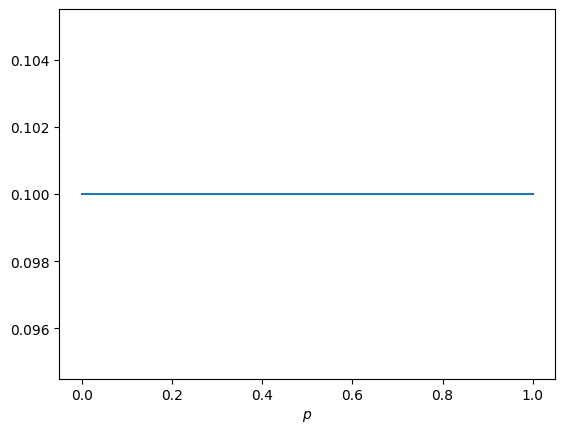

In [6]:
fig, ax = plt.subplots()
ax.plot(p_grid, prior, label="Prior distribution")
_ = ax.set_xlabel(r'$p$')

In [7]:
likelihood = binomial(experiment.count('W'), 
                      experiment.count('L'), p_grid)

In [8]:
posterior =  prior * likelihood
posterior = posterior/posterior.sum()

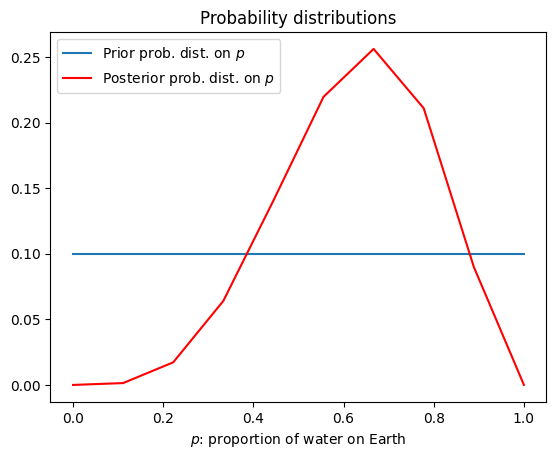

In [9]:
fig, ax = plt.subplots()
ax.plot(p_grid, prior, label=r"Prior prob. dist. on $p$")
ax.plot(p_grid, posterior, color='red', label=r"Posterior prob. dist. on $p$")
ax.set_xlabel('$p$: proportion of water on Earth')
ax.legend()
_ = ax.set_title("Probability distributions")

Now imagine a new experiments gets 10 Lands (and 0 Water). We can start from the previous "posterior" as the new "prior".

In [10]:
posterior2 =  posterior * binomial(0, 10, p_grid)
posterior2 = posterior2/posterior2.sum()

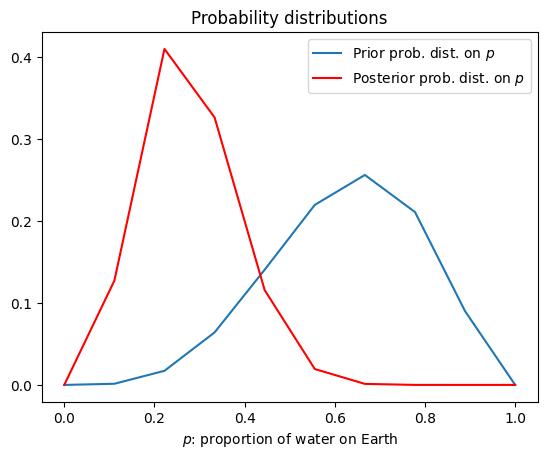

In [11]:
fig, ax = plt.subplots()
ax.plot(p_grid, posterior, label=r"Prior prob. dist. on $p$")
ax.plot(p_grid, posterior2, color='red', label=r"Posterior prob. dist. on $p$")
ax.set_xlabel('$p$: proportion of water on Earth')
ax.legend()
_ = ax.set_title("Probability distributions")

In [13]:
import pymc as pm # type: ignore

In [14]:
with pm.Model() as m1:
    prior_p = pm.Uniform("p", lower=0, upper=1)
    w = pm.Binomial("w", p=prior_p, n=len(experiment), observed=experiment.count('W'))
m1   

The model can be used to sample hypothetical (fake) data for experiments with 6 W/L values.

In [15]:
with m1:
    fake_experiments = pm.draw(w, draws=20)

In [16]:
fake_experiments

array([4, 2, 2, 0, 6, 3, 6, 4, 4, 4, 2, 0, 3, 5, 5, 4, 1, 3, 0, 6],
      dtype=int64)

But the most common use is to sample values from the posterior (i.e., after having seen the `observed` values) distribution of $p$

In [18]:
with m1:
    posterior_p = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [19]:
import arviz as az # type: ignore

In [20]:
az.summary(posterior_p)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.615,0.163,0.327,0.908,0.004,0.003,1587.0,2247.0,1.0


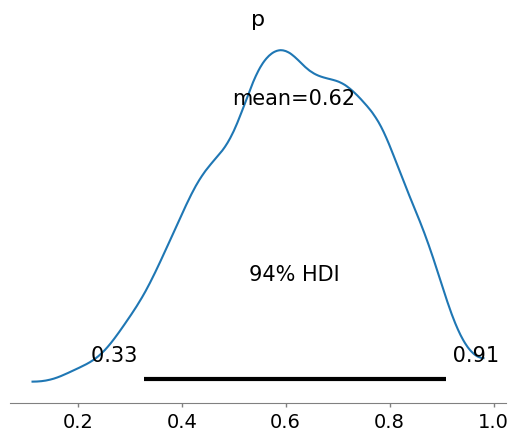

In [21]:
_ = az.plot_posterior(posterior_p)

With PyMC there is no easy way to use directly the sampled posterior as the prior in a new model. However, since we know some summary parameters (mean is ~0.62 and standard deviation ~0.16) we can use a Normal distribution to approximate it without losing too much.

In [22]:
m, s = az.extract(posterior_p)['p'].mean().to_numpy(), az.extract(posterior_p)['p'].std().to_numpy()

with pm.Model() as m2:
    prior_p = pm.Normal("p", mu=m, sigma=s)
    # The new experiment gave only lands
    w = pm.Binomial("w", p=prior_p, n=10, observed=0)


In [23]:
with m2:
    posterior2_p = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 369 divergences after tuning. Increase `target_accept` or reparameterize.


There were some "divergences" during the sampling: in fact, the new experiment somewhat subverts the posterior estimate (now used as the prior) of the first one. Consequently is more difficult to fit the data with such a model.

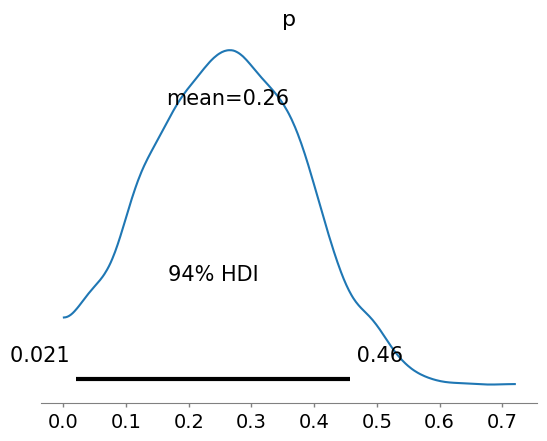

In [24]:
_ = az.plot_posterior(posterior2_p)

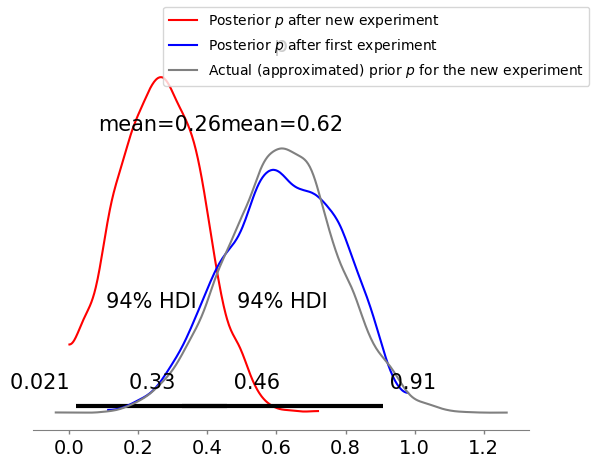

In [25]:
fig, ax = plt.subplots()
az.plot_posterior(posterior2_p, ax=ax, color='red',  label=r'Posterior $p$ after new experiment')
az.plot_posterior(posterior_p, ax=ax, color='blue', label=r'Posterior $p$ after first experiment')
az.plot_dist(np.random.normal(m, s, 10000), ax=ax, color='gray', label=r'Actual (approximated) prior $p$ for the new experiment')
ax.legend([])
_ = fig.legend()